In [250]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
# from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [251]:
RANDOM_STATE = 42

API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.13.453.3037' # '12.12.450.4196''12.13.453.3037' Version 12.12.448.6653 12.11.446.9344 Version 12.13.453.3037 (Jul 11 2022/18:39:20) [PUBLIC] <Releases/12.13>
PATCH: date = date(2022, 7, 16)  # date(2022, 7, 1) date(2022, 7, 16)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [252]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [253]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [254]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0          TFT7_Augment_MageConference
augment1            TFT7_Augment_BestFriends1
augment2             TFT7_Augment_MysticTrait
Set7_Assassin                             0.0
Set7_Astral                               1.0
                             ...             
TFT7_Zoe_item1                           None
TFT7_Zoe_item2                           None
items_count                                12
traits_sum                               11.0
units_sum                                30.0
Name: 2612, Length: 270, dtype: object

In [255]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

matches_df = X.copy()
matches_df[TARGETNAME] = y

# Augments Ranking

## Stage 2-1 augment ranking

In [256]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')
# group and aggregate mean/median
dct = {'Value_Count': ('augment0', 'count'), 'average_placement': ('placement', 'mean')}
augment0_rank_df = m.groupby('augment0', as_index=False).agg(**dct).sort_values(by='average_placement')
augment0_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_31156\207590299.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')


,augment0,Value_Count,average_placement
133,TFT7_Augment_MageConferenceHR,4,2.000000
147,TFT7_Augment_Preparation2HR,3,2.000000
154,TFT7_Augment_RevelEmblem2,148,3.405405
80,TFT7_Augment_AssassinEmblem2,107,3.504673
117,TFT7_Augment_GuardianEmblem,37,3.621622
174,TFT7_Augment_TempestEmblem2,10,3.700000
118,TFT7_Augment_GuardianEmblem2,4,3.750000
130,TFT7_Augment_JadeTrait2,20,3.850000
48,TFT6_Augment_PortableForge,578,3.916955
116,TFT7_Augment_GadgetExpert,480,3.935417


In [257]:
augment0_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment0_ranking.csv'), index=False)

## Stage 3-2 augment ranking

In [258]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')
# group and aggregate mean/median
dct = {'Value_Count': ('augment1', 'count'), 'average_placement': ('placement', 'mean')}
augment1_rank_df = m.groupby('augment1', as_index=False).agg(**dct).sort_values(by='average_placement')
augment1_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_31156\1890264867.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')


,augment1,Value_Count,average_placement
114,TFT7_Augment_EvokerEmblem2,1,2.000000
65,TFT6_Augment_Traitless1,26,2.615385
131,TFT7_Augment_JadeTrait2,15,2.866667
70,TFT6_Augment_TriForce3,17,2.941176
140,TFT7_Augment_MirageEmblem2,24,3.250000
184,TFT7_Augment_WhispersEmblem2,11,3.272727
161,TFT7_Augment_ShapeshifterBeastsDen,44,3.272727
150,TFT7_Augment_RagewingEmblem2,7,3.285714
69,TFT6_Augment_TriForce2,37,3.432432
159,TFT7_Augment_ScalescornEmblem2,19,3.526316


In [259]:
augment1_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment1_ranking.csv'), index=False)

## Stage 4-2 augment ranking

In [260]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')
# group and aggregate mean/median
dct = {'Value_Count': ('augment2', 'count'), 'average_placement': ('placement', 'mean')}
augment2_rank_df = m.groupby('augment2', as_index=False).agg(**dct).sort_values(by='average_placement')
augment2_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_31156\3922423790.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')


,augment2,Value_Count,average_placement
55,TFT6_Augment_Traitless1,2,1.500000
57,TFT6_Augment_Traitless3,4,1.500000
25,TFT6_Augment_Featherweights3,1,2.000000
56,TFT6_Augment_Traitless2,11,2.363636
135,TFT7_Augment_RevelPartyFavorsHR,1,3.000000
142,TFT7_Augment_ShapeshifterTrait,27,3.481481
12,TFT6_Augment_CyberneticShell1,73,3.630137
59,TFT6_Augment_TriForce2,14,3.714286
66,TFT7_Augment_AssassinEmblem2,41,3.804878
51,TFT6_Augment_TheGoldenEgg,166,3.897590


In [261]:
augment2_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment2_ranking.csv'), index=False)

# Items Ranking

In [262]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [263]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,4.0


In [264]:
# Get top5 value_count >= 12
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [265]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [266]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_top5_items.csv'), index=False)

## Top 1 items

In [267]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, TitanicHydra",12,3.750000
3,TFT7_Anivia,"ArchangelsStaff, Morellonomicon, SpearOfShojin",19,4.368421
8,TFT7_AoShin,"GuinsoosRageblade, RabadonsDeathcap, SpearOfShojin",14,2.357143
13,TFT7_Ashe,"LastWhisper, None, None",14,2.928571
18,TFT7_AurelionSol,"None, None, None",25010,4.499960
22,TFT7_Bard,"None, None, RunaansHurricane",21,2.047619
27,TFT7_Braum,"BrambleVest, None, None",26,3.961538
32,TFT7_Corki,"GuinsoosRageblade, StatikkShiv, StatikkShiv",19,3.210526
37,TFT7_Diana,"InfinityEdge, IonicSpark, RedBuff",16,2.875000
42,TFT7_DragonBlue,"Quicksilver, RevelEmblemItem, StatikkShiv",39,3.205128


# Load TFT asset

In [268]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [269]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [270]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [271]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [272]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [273]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [274]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [275]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Mie-Drn-DragonBlue,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Whs-Gun-Thresh,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,1.0
1,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0
2,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
3,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,Rag-Swt-Xayah",1,1.0
4,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
...,...,...,...
12487,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Mie-War-Yone",1,8.0
12488,"Scn-Gun-Braum,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana,Gud-Swt-Twitch",1,8.0
12489,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,She-Spf-Mae-Zoe",1,8.0
12490,"Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0


In [276]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [277]:
# from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('all-MiniLM-L6-v2')

2022-07-18 23:30:06,663 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-07-18 23:30:06,888 [INFO] Use pytorch device: cpu


In [278]:
# corpus_sentences = list(comp_ranking_df['comp'])

# corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches: 100%|██████████| 25/25 [03:14<00:00,  7.80s/it]


In [279]:
# clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
# predict=clustering_model.fit_predict(corpus_embeddings)
# comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [280]:
# comp_ranking_df.sort_values(by='group')

,comp,value_count,average_placement,group
0,"Mie-Drn-DragonBlue,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Whs-Gun-Thresh,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,1.0,0
1887,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,2.0,1
1866,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Asn-Qiyana,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,2.0,1
5416,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Swt-Ezreal,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,4.0,1
5379,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Shr-Gnar,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,4.0,1
...,...,...,...,...
12471,"Whs-Brr-Drn-DragonPurple,Asl-Brr-Illaoi,Mie-Car-Nunu,Scn-Brr-War-Olaf,Gud-Car-Sejuani,Whs-Mae-Brr-Sylas",1,8.0,3586
12480,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Jae-Str-Soraka,Gud-Swt-Twitch,Mie-War-Yone",1,8.0,3587
12489,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,She-Spf-Mae-Zoe",1,8.0,3588
12490,"Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0,3589


In [281]:
# comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [282]:
# comp_ranking_df.sort_values(by='group')[:60]

,comp,value_count,average_placement,group,grp_count,grp_placement
0,"Mie-Drn-DragonBlue,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Whs-Gun-Thresh,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,1.0,0,1,1.000000
1887,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,2.0,1,8,3.142857
1866,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Asn-Qiyana,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,2.0,1,8,3.142857
5416,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Swt-Ezreal,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,4.0,1,8,3.142857
5379,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Shr-Gnar,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,4.0,1,8,3.142857
6420,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",2,5.0,1,8,3.142857
1,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0,1,8,3.142857
5368,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Mie-Drr-War-Yasuo",1,4.0,1,8,3.142857
5469,"Jae-Drr-Swt-Ashe,Jae-Drr-Karma,Tet-Drr-LeeSin,Mie-Gun-Leona,Rag-Drr-Sett,Rag-Drr-Shr-Swain,Jae-Gun-Taric,She-Drr-Led-Volibear",1,4.0,2,861,4.711131
5443,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Drr-Shr-Swain,Rag-Swt-Xayah",1,4.0,2,861,4.711131


In [283]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [284]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

# top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [285]:
# top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,comp,value_count,average_placement,group,grp_count,grp_placement,mode
152,"AoShin, Bard, Elise, Gnar, Neeko, Ornn, Soraka, Sylas, Yasuo, Zoe",1,1.000000,57,278,2.741354,"AoShin, Bard, DragonPurple, Nami, Ornn, Sylas, Zoe"
781,"DragonPurple, Illaoi, Nami, Skarner, Sylas, Twitch, Varus, Zoe",1,1.000000,345,19,2.876786,"DragonPurple, Illaoi, LeeSin, Nami, Sylas, Twitch, Varus, Zoe"
995,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon, Twitch",2,1.500000,419,11,3.062500,"Diana, Illaoi, Olaf, Ornn, Qiyana, Shen, Talon, Twitch"
6,"Bard, DragonBlue, Hecarim, Nunu, Soraka, Yasuo, Zoe",1,1.000000,4,26,3.120000,"Bard, DragonBlue, Hecarim, Leona, Nunu, Sejuani, Yasuo, Zoe"
67,"Bard, Elise, Gnar, Neeko, Shyvana, Soraka, Thresh",1,1.000000,42,590,3.154675,"Bard, Braum, Diana, Hecarim, Lillia, Lulu, Olaf, Sejuani"
...,...,...,...,...,...,...,...
3495,"Heimerdinger, Illaoi, Lillia, Nami, Ryze, Sylas, Thresh, Vladimir",1,4.000000,1209,39,6.748328,"Heimerdinger, Illaoi, Lillia, Nami, Nidalee, Ryze, Sejuani, Skarner, Vladimir"
2793,"Lillia, Nunu, Ornn, Ryze, Sejuani, Sylas, Talon, Twitch",1,3.000000,992,19,6.750000,"Diana, Lillia, Nunu, Ornn, Ryze, Sejuani, Talon, Twitch"
5815,"Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, Vladimir",4,6.000000,2136,11,6.750000,"Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, Vladimir"
4976,"Heimerdinger, Illaoi, Nami, Sona, Sylas, Vladimir",1,5.000000,1781,10,6.809524,"Heimerdinger, Illaoi, Nami, Pyke, Ryze, Sylas, Vladimir"


In [286]:
# comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
# comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_comp_ranking.csv'), index=False)

In [287]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [288]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [289]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [290]:
composition_ranking_df

,comp,value_count,average_placement
0,"Mie-Drn-DragonBlue,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Whs-Gun-Thresh,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,1.0
1,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0
2,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
3,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,Rag-Swt-Xayah",1,1.0
4,"Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Drr-Karma,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Jae-Str-Soraka,Mie-Drr-War-Yasuo",1,1.0
...,...,...,...
12487,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Mie-War-Yone",1,8.0
12488,"Scn-Gun-Braum,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana,Gud-Swt-Twitch",1,8.0
12489,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,She-Spf-Mae-Zoe",1,8.0
12490,"Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0


# KMode
using - comp string

In [291]:
# # Elbow curve to find optimal K
# cost = []
# K = range(5,30,5)
# for num_clusters in list(K):
#     kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
#     kmode.fit_predict(composition_ranking_df)
#     cost.append(kmode.cost_)
    
# plt.plot(K, cost, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [292]:
# # Building the model with 3 clusters
# kmode = KModes(n_clusters=15, init = "random", n_init = 5, verbose=1)
# clusters = kmode.fit_predict(composition_ranking_df)
# clusters

In [293]:
# kmode_ranking_df = composition_ranking_df.copy()
# kmode_ranking_df.insert(0, "group", clusters, True)

In [294]:
# kmode_ranking_df

In [295]:
# kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [296]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [297]:
# kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
# kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

# _

In [298]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [299]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [300]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
5646,1,0,0,0,0,0,0,2,0,2,...,2,0,0,0,0,0,1,0,1,0
16761,1,0,0,0,0,0,1,2,2,0,...,0,0,1,0,0,0,0,1,0,0
2472,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,1,0,0,0,1,0
16756,1,0,1,0,0,0,2,2,3,0,...,0,0,1,0,0,0,0,1,0,0
9444,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22493,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2108,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
18037,8,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2
2127,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## KMode
using integers

In [301]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7879, cost: 290735.0
Run 1, iteration: 2/100, moves: 2269, cost: 289291.0
Run 1, iteration: 3/100, moves: 371, cost: 289291.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7622, cost: 293813.0
Run 2, iteration: 2/100, moves: 1802, cost: 292914.0
Run 2, iteration: 3/100, moves: 32, cost: 292914.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9812, cost: 305574.0
Run 3, iteration: 2/100, moves: 3996, cost: 304216.0
Run 3, iteration: 3/100, moves: 111, cost: 304216.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8000, cost: 303931.0
Run 4, iteration: 2/100, moves: 3538, cost: 301014.0
Run 4, iteration: 3/100, moves: 1140, cost: 301014.0
Init: initializing centroids
Init: initializing 

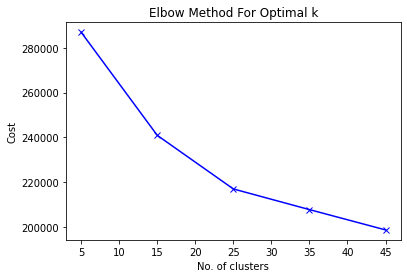

In [302]:
# Elbow curve to find optimal K
cost = []
K = range(5,50,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [303]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7469, cost: 223237.0
Run 1, iteration: 2/100, moves: 2564, cost: 221723.0
Run 1, iteration: 3/100, moves: 937, cost: 221723.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9389, cost: 229294.0
Run 2, iteration: 2/100, moves: 4232, cost: 226862.0
Run 2, iteration: 3/100, moves: 2646, cost: 225193.0
Run 2, iteration: 4/100, moves: 806, cost: 224993.0
Run 2, iteration: 5/100, moves: 23, cost: 224993.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9004, cost: 227919.0
Run 3, iteration: 2/100, moves: 3324, cost: 224829.0
Run 3, iteration: 3/100, moves: 2010, cost: 222591.0
Run 3, iteration: 4/100, moves: 1187, cost: 222068.0
Run 3, iteration: 5/100, moves: 370, cost: 221935.0
Run 3, iteration: 6/100, moves: 152, cost: 221935.0
Init: initializing centr

array([ 6, 10,  4, ..., 16,  5, 22], dtype=uint16)

In [304]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [305]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
5646,6,1,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
16761,10,1,0,0,0,0,0,1,2,2,...,0,0,1,0,0,0,0,1,0,0
2472,4,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,1,0
16756,10,1,0,1,0,0,0,2,2,3,...,0,0,1,0,0,0,0,1,0,0
9444,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22493,21,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2108,13,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
18037,16,8,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2
2127,5,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [306]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [307]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [308]:
kmode_ranking_df

,placement,group,comp
18249,2,0,"AoShin, Lulu, Nami, Neeko, Ornn, Sylas, Yasuo, Zoe"
12445,1,0,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Yasuo, Zoe"
22019,2,0,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Soraka, Sylas, TrainerDragon, Zoe"
24146,5,0,"AoShin, Lulu, Nami, Ornn, Shen, Sylas, Zoe"
19706,1,0,"Bard, DragonPurple, Illaoi, Ornn, Ryze, Sylas, Yasuo, Zoe"
...,...,...,...
6007,7,24,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Swain, Volibear"
9535,7,24,"Ashe, Hecarim, Karma, Neeko, Sett, Shyvana, Swain, Yasuo"
14252,1,24,"Ashe, Gnar, LeeSin, Neeko, Sett, Shyvana, Swain, Yasuo"
14159,4,24,"Ashe, Bard, Karma, LeeSin, Neeko, Ornn, Shen, Yasuo"


In [309]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [310]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
18249,2,0,"AoShin, Lulu, Nami, Neeko, Ornn, Sylas, Yasuo, Zoe",1320,2.822727
12445,1,0,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Yasuo, Zoe",1320,2.822727
22019,2,0,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Soraka, Sylas, TrainerDragon, Zoe",1320,2.822727
24146,5,0,"AoShin, Lulu, Nami, Ornn, Shen, Sylas, Zoe",1320,2.822727
19706,1,0,"Bard, DragonPurple, Illaoi, Ornn, Ryze, Sylas, Yasuo, Zoe",1320,2.822727
...,...,...,...,...,...
6007,7,24,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Swain, Volibear",610,5.121311
9535,7,24,"Ashe, Hecarim, Karma, Neeko, Sett, Shyvana, Swain, Yasuo",610,5.121311
14252,1,24,"Ashe, Gnar, LeeSin, Neeko, Sett, Shyvana, Swain, Yasuo",610,5.121311
14159,4,24,"Ashe, Bard, Karma, LeeSin, Neeko, Ornn, Shen, Yasuo",610,5.121311


In [311]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [312]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
18249,2,0,"AoShin, Lulu, Nami, Neeko, Ornn, Sylas, Yasuo, Zoe",1320,2.822727,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Zoe"
9216,1,11,"Bard, DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka, Yasuo",459,3.074074,"Bard, DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka"
16388,2,9,"Heimerdinger, Lillia, Lulu, Nami, Ryze, Shyvana, TrainerDragon, Zoe",108,3.166667,"Heimerdinger, Lillia, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir, Zoe"
23808,1,18,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sona, Sylas, TrainerDragon, Vladimir, Zoe",636,3.746855,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe"
21736,3,10,"Bard, Corki, Lulu, Neeko, Ornn, Shen, Sona, TrainerDragon, Tristana",1125,3.804444,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
13336,4,6,"Braum, Diana, Lillia, Olaf, Ornn, Pyke, Qiyana, Talon",1279,3.826427,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
17954,4,2,"Elise, Gnar, Karma, Neeko, Nidalee, Sett, Shyvana, Swain, Sylas",902,3.961197,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
23061,1,8,"DragonPurple, Heimerdinger, Lulu, Ornn, Pyke, Qiyana, Sylas, TrainerDragon, Zoe",976,3.998975,"Corki, DragonPurple, Heimerdinger, Lulu, Sona, Sylas, TrainerDragon, Zoe"
14621,5,17,"Ezreal, Illaoi, Ornn, Shen, Sylas, Twitch, Varus, Xayah",903,4.006645,"Illaoi, Lulu, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
7242,1,12,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Talon",1322,4.009834,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"


In [313]:
kmode_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmode_comp_ranking.csv'), index=False)

## KMeans

In [314]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

5646     1
16761    1
2472     1
16756    1
9444     1
        ..
22493    8
2108     8
18037    8
2127     8
17472    8
Name: placement, Length: 25416, dtype: int64

In [315]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 9594.119540891663.
Iteration 1, inertia 6898.678534906139.
Iteration 2, inertia 6714.580272266459.
Iteration 3, inertia 6651.543682222141.
Iteration 4, inertia 6613.374466126785.
Iteration 5, inertia 6591.5637505154455.
Iteration 6, inertia 6573.657558709637.
Iteration 7, inertia 6547.6430396732285.
Iteration 8, inertia 6522.95484596836.
Iteration 9, inertia 6513.13576690397.
Iteration 10, inertia 6509.193752267886.
Iteration 11, inertia 6506.118825548439.
Iteration 12, inertia 6504.843446147972.
Iteration 13, inertia 6504.161959310462.
Iteration 14, inertia 6503.6248393652895.
Iteration 15, inertia 6503.22356273522.
Iteration 16, inertia 6502.740980704448.
Iteration 17, inertia 6502.351555311643.
Iteration 18, inertia 6501.965264090595.
Iteration 19, inertia 6501.516998951019.
Iteration 20, inertia 6500.917517614251.
Iteration 21, inertia 6500.302194402756.
Iteration 22, inertia 6499.666511508275.
Iteration 23, inertia 6498.809789655034.
It

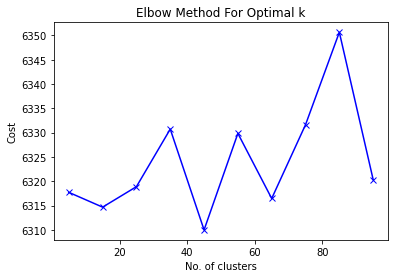

In [316]:
# Elbow curve to find optimal K
cost = []
K = range(5,100,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [317]:
# Building the model with 30 clusters
kms = KMeans(n_clusters=30, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 11530.561012870514.
Iteration 1, inertia 7431.8746444264325.
Iteration 2, inertia 7287.976569020283.
Iteration 3, inertia 7254.286405101225.
Iteration 4, inertia 7237.609572725129.
Iteration 5, inertia 7224.070407898815.
Iteration 6, inertia 7211.4002134971715.
Iteration 7, inertia 7195.5362819445345.
Iteration 8, inertia 7176.972587248683.
Iteration 9, inertia 7160.8969966693085.
Iteration 10, inertia 7155.584304420144.
Iteration 11, inertia 7153.032994330544.
Iteration 12, inertia 7150.674039113275.
Iteration 13, inertia 7148.59054885034.
Iteration 14, inertia 7147.310985791909.
Iteration 15, inertia 7146.615111640086.
Iteration 16, inertia 7146.056919576964.
Iteration 17, inertia 7145.5086707422.
Iteration 18, inertia 7144.971122125284.
Iteration 19, inertia 7144.824025926718.
Iteration 20, inertia 7144.718321144242.
Iteration 21, inertia 7144.648748338579.
Iteration 22, inertia 7144.540639458873.
Iteration 23, inertia 7144.447950522427.


array([27, 24, 21, ..., 12, 26,  3])

In [318]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [319]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
5646,27,1,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
16761,24,1,0,0,0,0,0,1,2,2,...,0,0,1,0,0,0,0,1,0,0
2472,21,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,1,0
16756,24,1,0,1,0,0,0,2,2,3,...,0,0,1,0,0,0,0,1,0,0
9444,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22493,13,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2108,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
18037,12,8,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2
2127,26,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [320]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [321]:
kmeans_ranking_df

,placement,group,comp
23082,3,0,"DragonBlue, Hecarim, Nunu, Sejuani, Talon, Yasuo, Yone"
7562,6,0,"DragonBlue, Hecarim, Leona, Lillia, Nunu, Sejuani, Yone"
12783,6,0,"DragonBlue, Gnar, Hecarim, Neeko, Nunu, Sejuani, Yasuo"
5157,3,0,"DragonBlue, Hecarim, Nunu, Sejuani, Thresh, Yasuo, Yone"
2531,6,0,"DragonBlue, Hecarim, Leona, Nunu, Yasuo"
...,...,...,...
7284,1,29,"Hecarim, Kayn, Sett, Shyvana, Swain, Xayah, Yasuo"
17257,8,29,"Hecarim, Senna, Sett, Shen, Swain, Xayah"
25027,5,29,"Ashe, Bard, DragonGreen, Neeko, Sett, Soraka, Swain, Xayah"
9358,5,29,"Bard, Hecarim, Kayn, Neeko, Senna, Sett, Shen, Swain, Volibear"


In [322]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [323]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
11204,5,19,"AoShin, Heimerdinger, Illaoi, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe",1200,3.251667,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Zoe"
13902,6,5,"AoShin, Bard, Heimerdinger, Nami, Ornn, Sylas, Vladimir",737,3.614654,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Zoe"
334,2,27,"Braum, Diana, Lillia, Olaf, Ornn, Qiyana, Shen, Yasuo, Yone",1041,3.952930,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
6988,1,16,"Diana, DragonPurple, Kayn, Ornn, Pyke, Qiyana, Shen, Talon",734,3.972752,"Diana, DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon"
9138,3,11,"Bard, DragonPurple, Illaoi, Nami, Ornn, Twitch, Varus",673,4.104012,"Illaoi, Lulu, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
16104,2,17,"DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka, Thresh",818,4.180929,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
12980,7,14,"Anivia, Corki, DragonGreen, Gnar, Lulu, Neeko",860,4.325581,"Anivia, Ashe, DragonGreen, Gnar, Lulu, Neeko, Soraka"
17355,1,23,"Diana, Hecarim, Neeko, Ornn, Sona, Xayah",330,4.336364,"Bard, Corki, Hecarim, Neeko, Ornn, Pyke, Xayah, Yasuo"
18409,3,26,"Illaoi, Lulu, Nami, Ornn, Shen, Sylas, Twitch, Varus, Zoe",1186,4.381956,"Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus"
11809,2,10,"DragonPurple, Elise, Gnar, Neeko, Soraka, Sylas, Thresh",895,4.388827,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh"


In [324]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [325]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

5646     1
16761    1
2472     1
16756    1
9444     1
        ..
22493    8
2108     8
18037    8
2127     8
17472    8
Name: placement, Length: 25416, dtype: int64

In [326]:
units_composition_df.shape

(25416, 88)

In [327]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([ 0,  1, -1, ...,  1,  2, -1], dtype=int64)

In [328]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [329]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
5646,0,1,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
16761,1,1,0,0,0,0,0,1,2,2,...,0,0,1,0,0,0,0,1,0,0
2472,-1,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,1,0
16756,1,1,0,1,0,0,0,2,2,3,...,0,0,1,0,0,0,0,1,0,0
9444,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22493,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2108,4,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
18037,1,8,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2
2127,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [330]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [331]:
dbscan_ranking_df

,placement,group,comp
17472,8,-1,"Corki, Jinx, Lulu, Senna, Shen, Sona, TahmKench"
17618,2,-1,"Ashe, Corki, DragonGreen, Gnar, Karma, Neeko, Soraka"
9198,5,-1,"AoShin, Braum, Hecarim, Ornn, Sejuani, Soraka, Yasuo"
17640,2,-1,"Aatrox, Diana, Hecarim, Kayn, Lillia, Nunu, Sejuani, Shen"
17657,2,-1,"Bard, Corki, Hecarim, Jinx, Sejuani, Sona, TahmKench, Talon, Yasuo"
...,...,...,...
4439,3,179,"Hecarim, Lillia, Nami, Nunu, Olaf, Ryze, Sejuani, Sylas"
19752,2,179,"Hecarim, Lillia, Nami, Nunu, Pyke, Ryze, Sejuani, Sylas, Zoe"
22910,8,180,"Elise, Gnar, Illaoi, Nidalee, Skarner"
7526,6,180,"Gnar, Illaoi, Neeko, Nidalee, Skarner"


In [332]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
6642,6,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",6695.0,4.129512,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
10424,2,3,"Ashe, Karma, LeeSin, Neeko, Sett, Shen, Shyvana, Swain, Volibear",5816.0,4.696822,"Ashe, Karma, LeeSin, Neeko, Ornn, Sett, Shen, Swain"
4285,1,5,"Elise, Gnar, Neeko, Nidalee, Pyke, Shyvana, Soraka, Swain",4120.0,3.688985,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
21098,6,1,"Bard, Corki, DragonGold, Jinx, Lulu, Sona, TrainerDragon, Tristana",3158.0,4.618493,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
22928,1,2,"Ezreal, Hecarim, Illaoi, Ornn, Shen, Skarner, Twitch, Varus, Xayah",2747.0,4.177098,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir"
15100,6,10,"DragonPurple, Heimerdinger, Ornn, Qiyana, Sylas, Talon, Zoe",471.0,4.444444,"DragonPurple, Ornn, Qiyana, Ryze, Sylas, Talon, Zoe"
22689,1,6,"Bard, Corki, Heimerdinger, Ornn, Sona, Sylas, TrainerDragon, Tristana, Yasuo, Zoe",463.0,3.805970,"Bard, Corki, Heimerdinger, Lulu, Ornn, Sona, Sylas, TrainerDragon, Zoe"
7809,1,4,"Hecarim, Lillia, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",409.0,4.476699,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
6812,5,18,"Hecarim, Lillia, Nunu, Ryze, Sejuani, Talon, Twitch, Varus",149.0,4.200000,"Bard, Hecarim, Nunu, Ryze, Sejuani, Talon, Twitch, Varus"
273,1,8,"Hecarim, Kayn, Sett, Shen, Shyvana, Swain, Xayah, Yasuo",142.0,2.967742,"Hecarim, Kayn, Sett, Shen, Shyvana, Swain, Xayah"


In [333]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_dbscan_comp_ranking.csv'), index=False)